# Project work

## TASKS
1. Data cleaning and preparation
2. Explorative analysis
    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.
3. Statistical Analysis
    - Do testing -> T-test, chi-square, ANOVA jne.
    - Confidence intervals and Estimation about parameter(s) that best represent the population
    - Regression and modeling
    - Hyphothese and its testing
4. Must do a statistical model

## Reviewing criteria
1. Data preparation DONE
2. Use of descriptive statistics -> Working ON
3. Use of estimation and statistical test -> NEXT UP
4. Argumentation for design choices -> Working ON 
5. interpretation of results

##
## Tasks from the hypothetical scheme
1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    - Distributions for all categorical values DONE
    - Find out if certain age, sex, and municipality groups have similiar activities ALMOST DONE
2. Estimate how much time on average households spend daily on each activity.
    - try out mean and medians for activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # found from online tutorial
# import seaborn as sns



In [254]:
# Loading data
df = pd.read_csv('./habits.data',
                sep=";",
                na_values=["?"],
                index_col=False,
                header=0)

Ikäluokkaryhmiä 1-2 eli alle 20 vuotiaita ei ole tuloksissa ollenkaan
Vastanneiden painopiste intuitiivisesti on jossain luokan 6 kohdalla.
Vastaa intuitiivisesti yläpäähän painottuvaa normaalijakaumaa

#### Demographic variables
- kohde - household ID: nominal
- jasen - member ID (within household): nominal
- pvknro - day of week: categorical, nominal and binary
    - 1 = working day
    - 2 = weekend

- sp - sex: categorical, nominal and binary
    - 1 = male
    - 2 = female
- IKAL1 - age group: categorical, ordinal
    - 1 = 10-14 years old
    - 2 = 15-19 years old
    - 3 = 20-24 years old
    - 4 = 25-34 years old
    - 5 = 35-44 years old
    - 6 = 45-54 years old
    - 7 = 55-64 years old
    - 8 = 65-74 years old
    - 9 = 75- years old

- ASALUE - living environment: categorical, nominal
    - 1 = city
    - 2 = municipality
    - 3 = rural area

#### Activity variables
Time spent on activities (measured in minutes): Quantitative, ratio

- V1 - working: ratio
- V5 - cooking: ratio
- V21 - childcare: ratio
- V22 - reading and playing with children: ratio

Place visited in past 12 months 
- Values: Categorical, indicator, binary
    - 1 = yes
    - 2 = no

- H1a_A - cinema: indicator
- H1b_A - theater: indicator


## 1. Data preparation

### Initial column deletion

At first glance NaN-values will be dropped, but may change over the study if effect on results seem good either way. 

At first I thought of filling zero values with mean or medians but they would heavily influence the results pushing up correlation and other metrics. It seems that particioners have deliberatley chosen 0 minutes and therefore they are not active on these metrics at all. This must be included in the results.

In [255]:
# Keep relevant columns
columns_to_keep = ['kohde', 
                   'jasen', 
                   'pvknro', 
                   'sp', 
                   'IKAL1', 
                   'ASALUE', 
                   'V1', 
                   'V21', 
                   'V22', 
                   'V5', 
                   'H1a_A', 
                   'H1b_A']
df = df[columns_to_keep].copy()
# df

In [256]:
# Renaming columns
df.rename(columns={'kohde': 'household_id', 
                   'jasen': 'member_id', 
                   'pvknro': 'day_of_week', 
                   'sp': 'sex', 
                   'IKAL1': 'age_group', 
                   'ASALUE': 'area', 
                   'V1': 't_working', 
                   'V21': 't_cooking', 
                   'V22': 't_childcare', 
                   'V5': 't_activity_w_child', 
                   'H1a_A': 'visited_cinema', 
                   'H1b_A': 'visited_theatre'
                   }, inplace=True)

In [257]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   household_id        745 non-null    int64  
 1   member_id           745 non-null    int64  
 2   day_of_week         745 non-null    int64  
 3   sex                 745 non-null    int64  
 4   age_group           745 non-null    int64  
 5   area                745 non-null    float64
 6   t_working           734 non-null    object 
 7   t_cooking           739 non-null    object 
 8   t_childcare         738 non-null    object 
 9   t_activity_w_child  740 non-null    object 
 10  visited_cinema      701 non-null    float64
 11  visited_theatre     701 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 70.0+ KB


In [258]:
# print(df.info(), "\n")
# print(df.describe().round(2), "\n")
print(df.isna().sum(),"\n")
# print(df.nunique(), "\n")

household_id           0
member_id              0
day_of_week            0
sex                    0
age_group              0
area                   0
t_working             11
t_cooking              6
t_childcare            7
t_activity_w_child     5
visited_cinema        44
visited_theatre       44
dtype: int64 



### Notes from initial data check

- 338 unique household IDs
- Other categorical values have all categories stated in data info
- In non-categoric values there is lots of NaN values. 
- Not taking NaNs in to account the data uniqueness seems ok. 
- At least the lower 25% has 0 minutes in all activities
- Dtypes are not correct


### Cleaning erroneous values

In [259]:
# df[['visited_cinema', 'visited_theatre']].value_counts() --> Shows bad values

# 'Visited_Cinema' and 'Visited_Theatre' has NaN values and other erroneous values
# Change errenoeus to NaN and then delete all rows containing NaN values

df['visited_cinema'] = df['visited_cinema'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df['visited_theatre'] = df['visited_theatre'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df.dropna(subset=['visited_cinema', 'visited_theatre'], inplace=True)

print(df.isna().sum())


household_id          0
member_id             0
day_of_week           0
sex                   0
age_group             0
area                  0
t_working             9
t_cooking             6
t_childcare           7
t_activity_w_child    4
visited_cinema        0
visited_theatre       0
dtype: int64


In [260]:
columns_to_clean = ['t_working','t_cooking', 't_childcare', 't_activity_w_child']
for column in columns_to_clean:
    df[column] = df[column].apply(
        lambda x: pd.to_numeric(x, errors='coerce')  # Convert to numeric, set invalid to NaN
    )
    df[column] = df[column].fillna(0).astype(int)  # Replace NaN with 0 before conversion

df.isna().sum()

household_id          0
member_id             0
day_of_week           0
sex                   0
age_group             0
area                  0
t_working             0
t_cooking             0
t_childcare           0
t_activity_w_child    0
visited_cinema        0
visited_theatre       0
dtype: int64

#### Dropping lines that have only 1 answer

After handling bad quality data, there is 23 households with that have answered only for weekend or weekday. Dropping them so all data has corresponding data for weekend and weekday.

In [261]:
# Testing if there are more than 2 answers per household
one = (df['household_id'].value_counts().copy() == 1).sum()
two = (df['household_id'].value_counts().copy() == 2).sum()
over_two = (df['household_id'].value_counts().copy() > 2).sum()

print("One: {}, Two: {}, Over Two: {}".format(one, two, over_two))

# 11 households have only 1 answer, dropping them
occurrences = df['household_id'].value_counts().copy()
household_ids = occurrences[occurrences == 1].index

# Dropping households with only 1 answer
df = df[~df['household_id'].isin(household_ids)].copy()
print("Lines deleted")

One: 23, Two: 326, Over Two: 0
Lines deleted


### Retyping data

In [262]:
# Retyping columns


df['household_id'] = df['household_id'].astype('int64')                 # Quantitative, discrete
df['member_id'] = pd.Categorical(df['member_id'])                       # Categorical, binary
df['day_of_week'] = pd.Categorical(df['day_of_week'])                   # Categorical, binary
df['sex'] = pd.Categorical(df['sex'])                                   # Categorical, binary
df['age_group'] = pd.Categorical(df['age_group'], ordered=True)         # Categorical, ordinal 
df['area'] = pd.Categorical(df['area'])                                 # Categorical, nominal

# Categorical, nominal, Int values measuring minutes
df['t_working'] = df['t_working'].astype('int64')
df['t_cooking'] = df['t_cooking'].astype('int64')
df['t_childcare'] = df['t_childcare'].astype('int64')
df['t_activity_w_child'] = df['t_activity_w_child'].astype('int64')

# Categorical, binary, indicator
df['visited_cinema'] = pd.Categorical(df['visited_cinema'])
df['visited_theatre'] = pd.Categorical(df['visited_theatre'])

df.dtypes


# Deleting NaN values or replacing with 0 -> if replaced, may introduce bias towards not going. 


household_id             int64
member_id             category
day_of_week           category
sex                   category
age_group             category
area                  category
t_working                int64
t_cooking                int64
t_childcare              int64
t_activity_w_child       int64
visited_cinema        category
visited_theatre       category
dtype: object

#### Values to human readable format

In [263]:
df['day_of_week'] = df['day_of_week'].replace({1: 'weekday', 2: 'weekend'})
df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
df['area'] = df['area'].replace({1: 'city', 2: 'municipality', 3: 'rural'})
df['age_group'] = df['age_group'].replace({
    1: "10-14",
    2: "15-19",
    3: "20-24",
    4: "25-34",
    5: "35-44",
    6: "45-54",
    7: "55-64",
    8: "65-74",
    9: "75+"
})
# Warnings of deprecated function but works

/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/1605943034.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['day_of_week'] = df['day_of_week'].replace({1: 'weekday', 2: 'weekend'})
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/1605943034.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/1605943034.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is depre

In [264]:
# Checking ID values for anomalies
print('ID max:', df.household_id.max())
print('ID min:', df.household_id.min())
print("Unique ID's:", df.household_id.nunique())

# Looks OK
# Few household_ids are missing since we deleted some rows and did not re_index++# Time spent in activities
# Check weekend and weekday separately


ID max: 51983
ID min: 50002
Unique ID's: 326


### Mapping tool if needed later on

In [265]:
# Tool for mapping the values for better presentation

map_day = {
    1: 'workday',
    2: 'weekend'
}

map_sex = {
    1: 'male',
    2: 'female'
}

map_age = {
    1: "10-14",
    2: "15-19",
    3: "20-24",
    4: "25-34",
    5: "35-44",
    6: "45-54",
    7: "55-64",
    8: "65-74",
    9: "75+"
}    

map_area = {
    1: "city",
    2: "municipality",
    3: "rural"
}

map_cinema = {
    1: "yes",
    2: "no"
}

map_theatre = {   
    1: "yes",
    2: "no"
}

mappable_columns = ['day_of_week', 'sex', 'age_group', 'area', 'visited_cinema', 'visited_theatre']
map_values = [map_day, map_sex, map_age, map_area, map_cinema, map_theatre]

def df_mapper(df, mappable_columns, map_values): 
    for i in range(len(mappable_columns)):
        df[mappable_columns[i]] = df[mappable_columns[i]].map(map_values[i])
    return df

# Copy enables to run again
df_copy = df.copy()
df_mapped = df_mapper(df_copy, mappable_columns, map_values)


<Axes: xlabel='Minutes', ylabel='Frequency'>

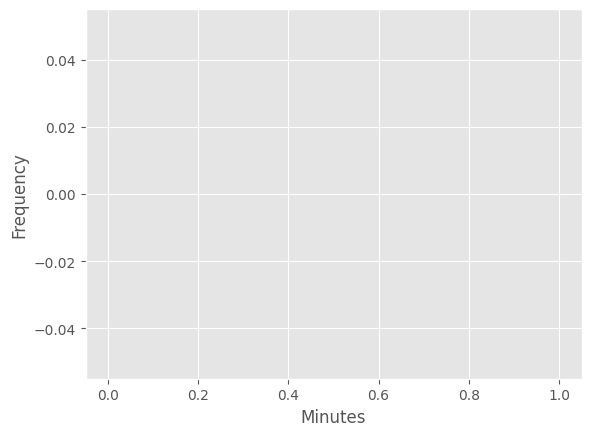

In [266]:
# If I want to see only males -> select Day_of_Week[Workday OR Weekday] AND Sex[Male OR Female]
female_workday = df_mapped[(df_mapped['day_of_week'] == 'workday') & (df_mapped['sex'] == 'female')].sort_values('age_group')
female_weekend = df_mapped[(df_mapped['day_of_week'] == 'weekend') & (df_mapped['sex'] == 'female')].sort_values('age_group')
male_workday = df_mapped[(df_mapped['day_of_week'] == 'workday') & (df_mapped['sex'] == 'male')].sort_values('age_group')
male_weekend = df_mapped[(df_mapped['day_of_week'] == 'weekend') & (df_mapped['sex'] == 'male')].sort_values('age_group')

male_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
male_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')
female_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
female_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')

### Questions that arises?

- Group differences
    - Working
    - Not working
    - Not working & caring child
    - Different age groups
    - Men and Women

- Member ID seems quite irreleveant, unless there is significant behaviour change in them

## 2. Explorative analysis

    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.

### Visuals and plotting

In [267]:
df.groupby('age_group')[['visited_cinema', 'visited_theatre']].value_counts()

/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/3306577168.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_group')[['visited_cinema', 'visited_theatre']].value_counts()


age_group  visited_cinema  visited_theatre
20-24      Yes             No                 18
                           Yes                14
           No              No                  6
                           Yes                 0
25-34      Yes             No                 34
                           Yes                30
           No              No                 24
                           Yes                 2
35-44      Yes             Yes                40
           No              No                 28
           Yes             No                 20
           No              Yes                16
45-54      Yes             Yes                52
           No              No                 38
                           Yes                32
           Yes             No                 22
55-64      No              No                 56
           Yes             Yes                46
           No              Yes                38
           Yes            

/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/915505195.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_group')[['visited_cinema', 'visited_theatre']].value_counts().unstack('age_group').plot.area(stacked=True)


<Axes: xlabel='visited_cinema,visited_theatre'>

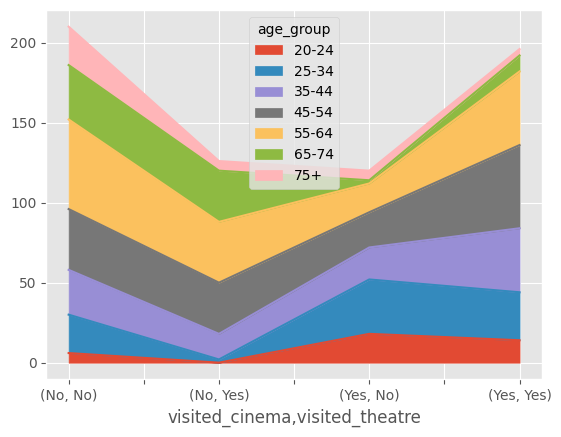

In [268]:
df.groupby('age_group')[['visited_cinema', 'visited_theatre']].value_counts().unstack('age_group').plot.area(stacked=True)

# Older people visit less culture events, especially less cinema but prefer only theartre or both but not only cinema.

In [269]:
df.groupby('day_of_week')[['visited_cinema', 'visited_theatre']].value_counts()

/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/1714193810.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('day_of_week')[['visited_cinema', 'visited_theatre']].value_counts()


day_of_week  visited_cinema  visited_theatre
weekday      No              No                 105
             Yes             Yes                 98
             No              Yes                 63
             Yes             No                  60
weekend      No              No                 105
             Yes             Yes                 98
             No              Yes                 63
             Yes             No                  60
Name: count, dtype: int64

In [270]:
# Chekcing rows where no time spent on any activity
time_columns = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
time_df = df[time_columns]
ids = df.loc[time_df[time_columns].sum(axis=1) == 0].household_id.value_counts()
print("Sum of id's with 0 minutes in all 4 fields:", len(ids))

ids = ids[ids > 1].index
print("Sum of id's where both weekend and weekday activities 0 minutes:", len(ids))
ids

df_no_activity = df[(df['household_id'].isin(ids)) & (df['visited_cinema'] == 'No') & (df['visited_theatre'] == 'No') ]
len(df_no_activity) / 2 # Amount of individuals that do none of the activities

Sum of id's with 0 minutes in all 4 fields: 111
Sum of id's where both weekend and weekday activities 0 minutes: 53


18.0

In [271]:
# Correlation between sex and member id
# df.loc[df['sex'] == 'male'].astype(int) = 1
# df['sex'].corr(df['member_id'])

/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/826827201.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([column])['household_id'].nunique().plot.bar(ax=axes[i], fontsize=14)
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/826827201.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([column])['household_id'].nunique().plot.bar(ax=axes[i], fontsize=14)
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/826827201.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas

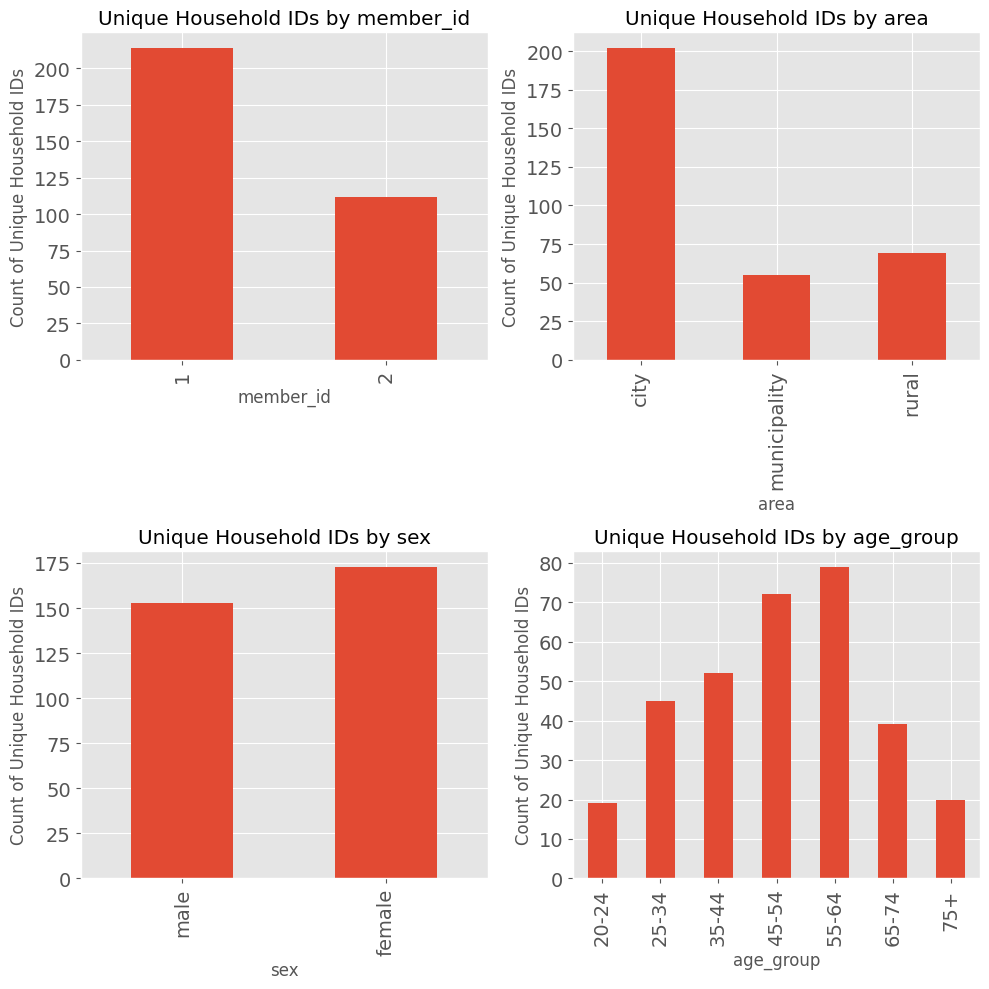

In [272]:
# Trying to create subplots with a loop
#  Age distributions in relation to sex, area are interesting 
demographics = ['member_id', 'area', 'sex', 'age_group']

columns = len(demographics)
rows = int(columns / 2)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, 5 * rows))
axes = axes.flatten()

# Previous method axes.flatten() creates a list to iterate over with a single digit
# Subplots for each column with demogrpaphic types
for i, column in enumerate(demographics):
    df.groupby([column])['household_id'].nunique().plot.bar(ax=axes[i], fontsize=14)
    axes[i].set_title(f'Unique Household IDs by {column}')
    axes[i].set_ylabel('Count of Unique Household IDs')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

# Density plots ???

# df[df['sex'] == 'female'].groupby(['age_group', 'area']).size().unstack().plot(xlabel='female', kind='bar', ax=axes[1], stacked=True)


/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/832096952.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_male = df[df['sex'] == 'male'][['household_id','age_group','area']].groupby(['age_group','area']).nunique()
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/832096952.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_female = df[df['sex'] == 'female'][['household_id','age_group','area']].groupby(['age_group', 'area']).nunique()


<Axes: ylabel='Density'>

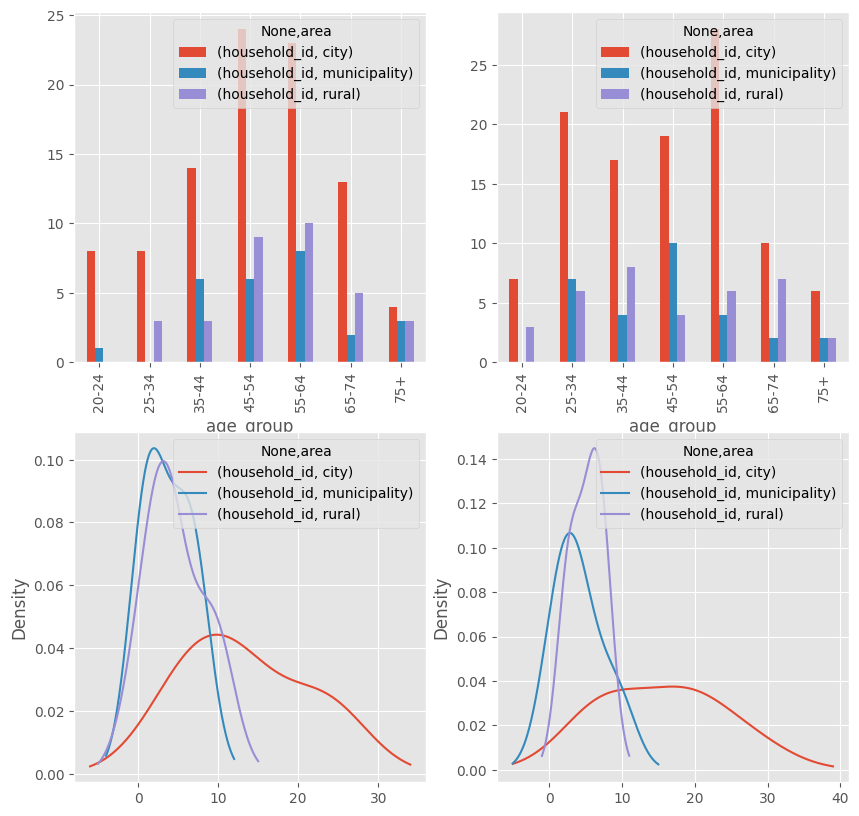

In [273]:
# Creating subplots individually
# Calculated in respect to individual households ~336

# Mean values for men and women living in different areas
df_male = df[df['sex'] == 'male'][['household_id','age_group','area']].groupby(['age_group','area']).nunique()
df_female = df[df['sex'] == 'female'][['household_id','age_group','area']].groupby(['age_group', 'area']).nunique()

fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=(10, 10))

df_male.unstack('area').plot(kind='bar', ax=axes[0,0])
df_male.unstack('area').plot(kind='density', ax=axes[1,0])
df_female.unstack('area').plot(kind='bar', ax=axes[0,1])
df_female.unstack('area').plot(kind='density', ax=axes[1,1])




/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/3884871879.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['sex'] == 'male'].groupby(['age_group','area']).size().unstack('area').plot(kind='density', ax=axes[0], fontsize=14, linewidth=2)
/var/folders/l7/_d80ffds11sdttwzxl1mww6w0000gn/T/ipykernel_62342/3884871879.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['sex'] == 'female'].groupby(['age_group', 'area']).size().unstack('area').plot(kind='density', ax=axes[1], fontsize=14, linewidth=2)


[Text(0.5, 0, 'Female')]

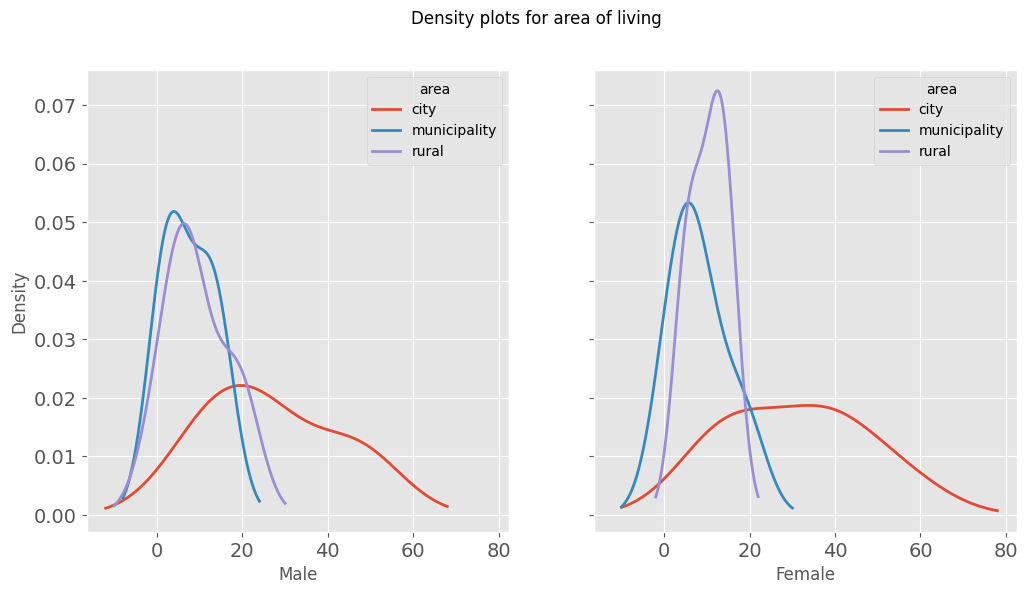

In [274]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         sharey=True, 
                         sharex=True, 
                         figsize=(12, 6)
                         )

df[df['sex'] == 'male'].groupby(['age_group','area']).size().unstack('area').plot(kind='density', ax=axes[0], fontsize=14, linewidth=2)
df[df['sex'] == 'female'].groupby(['age_group', 'area']).size().unstack('area').plot(kind='density', ax=axes[1], fontsize=14, linewidth=2)
fig.suptitle('Density plots for area of living')
axes[0].set(xlabel='Male')
axes[1].set(xlabel='Female')

In [275]:
# df.groupby(['area', 'sex', 'age']).size().unstack().plot(kind='bar', stacked=False)

In [276]:
sex_sums = df[['sex']].value_counts()
ratio = sex_sums.female.sum() / sex_sums.male.sum()
ratio
# There is {ratio} times more female than men overall

np.float64(1.130718954248366)

### Descriptives
Mean median std deviation and frequencies

In [319]:
list = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
# print(df['day_of_week' == 'Weekday'][list].std())

print(
df[df['day_of_week'] == 'weekday'][list].mean(),
'\n',
df[df['day_of_week'] == 'weekend'][list].mean()
)

t_working             112.638037
t_cooking              10.030675
t_childcare             3.558282
t_activity_w_child     29.355828
dtype: float64 
 t_working             102.423313
t_cooking              10.613497
t_childcare             4.969325
t_activity_w_child     29.509202
dtype: float64


### Categorical variables characteristics

In [277]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# df['age_group'].plot(kind='hist', bins=20, ax=axes[0], title='Histogram of IKAL1')

# Density plot

# df['age_group'].dropna().sort_values().plot(kind='density', ax=axes[1], title='Density Plot of ')

# plt.tight_layout()
# plt.show()

In [278]:
# df = df.apply(pd.to_numeric, errors='coerce')
# print(df.sum(axis=0).sort_values(ascending=False), end="\n\n")

In [279]:
# Living area distribution
mapped_df = df_mapper(df.copy(), mappable_columns, map_values)
counts = mapped_df['area'].value_counts().copy()

women_count = (mapped_df.drop_duplicates(subset='household_id')['sex'] == 'female').sum()
print(women_count)
area_sex_counts = mapped_df.groupby(['area', 'sex']).size().unstack().copy()
axis3 = (area_sex_counts / 2).plot(kind='bar', title='Distribution of Men and Women in Living Area')
axis3.set_xticklabels(axis3.get_xticklabels(), rotation=0)
   



0


TypeError: no numeric data to plot

In [ ]:
# Filter the dataframe to include only rows where Day_of_Week is 1
df_workday = df[df['day_of_week'] == 2].copy()

# Convert to numeric
df_scatter_workday = df_workday.apply(pd.to_numeric, errors='coerce')

# Select the columns to normalize (columns 5 to 9)
columns_to_normalize = df_scatter_workday.columns[5:10]

# Apply the rank method to normalize to percentiles
df_scatter_workday[columns_to_normalize] = df_scatter_workday[columns_to_normalize].rank(pct=True)

# Ensure 'Visited_Theatre' is of type int64
df_scatter_workday['visited_theatre'] = df_scatter_workday['visited_theatre'].astype('int64')

# Plot the scatter matrix
scatter_matrix = pd.plotting.scatter_matrix(df_scatter_workday.iloc[:, 4:10], figsize=(10, 10))


In [103]:
# Plot distributions of categorical variables

categorical_columns = ['day_of_week', 'sex', 'age_group', 'area']  # Day of week, Sex, Age, Area

# Create subplots for each categorical variable
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Loop through each categorical column and plot its distribution
# for i, column in enumerate(categorical_columns):
#     ax = axes[i//2, i%2]  # Organize subplots
#     df_mapped[column].value_counts().plot(kind='bar', ax=ax)
#     ax.set_title(f'Distribution of {column}')
#     ax.set_xlabel(column)
#     ax.set_ylabel('Count')
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis labels (make them horizontal)



### Patterns and hypothesis'

## 3. Statistical Analysis

### Statistical Tests

### Correlation

Overall could be assumed that age, sex and region will group particioners similiarly.

Correlations still are quite low generally with max values at around 0.43 and -0.27